# RSI - Relative Strength Index

Jaime Lopez \<jailop AT protonmail DOT com\>  
Jul. 12, 2024

This notebook shows an implementation for the RSI financial indicator. As case of study, TSLA stock prices on the second half of 2023 are used as example.

## Setting environment and retrieving data

In [157]:
# Setting the environment
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance

In [158]:
# Parameters
symbol = "TSLA"
start = "2023-07-01"
end = "2023-12-31"
period = "1d"

In [160]:
# Retrieving data
ticker = yfinance.Ticker(symbol)
data = ticker.history(start=start, end=end, period=period)
data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-12-22 00:00:00-05:00,256.760010,258.220001,251.369995,252.539993,93249800,0.0,0.0
2023-12-26 00:00:00-05:00,254.490005,257.970001,252.910004,256.609985,86892400,0.0,0.0
2023-12-27 00:00:00-05:00,258.350006,263.339996,257.519989,261.440002,106494400,0.0,0.0
2023-12-28 00:00:00-05:00,263.660004,265.130005,252.710007,253.179993,113619900,0.0,0.0
2023-12-29 00:00:00-05:00,255.100006,255.190002,247.429993,248.479996,100615300,0.0,0.0


## Step by step

In [161]:
# Difference relative between close and open prices
data["Diff"] = (data["Close"] - data["Open"]) / data["Close"]
# Gain if relative difference is positive
data["Gain"] = data["Diff"].apply(lambda diff: diff if diff >= 0.0 else 0.0)
# Loss if relative difference is negative
data["Loss"] = data["Diff"].apply(lambda diff: -diff if diff < 0.0 else 0.0)

$$\text{RSI}_{\text{step one}} = 100 - \frac{100}{1 + \frac{\text{Avg. Gain}}{\text{Avg. Loss}}}$$

In [162]:
start = 0
end = 15
avg_gain = data[start:end]["Gain"].sum() / (end - start - 1)
avg_loss = data[start:end]["Loss"].sum() / (end - start - 1)
rsi_step_one = 100 - 100 / (1 + avg_gain / avg_loss)
rsi_step_one

np.float64(42.92731873609142)

$$\text{RSI}_{\text{step two}} = 100 - \frac{100}{1 + \frac{\text{Avg. Gain} \times 13 + \text{Curr. Gain}}{\text{Avg. Loss} \times 13 + \text{Curr. Loss}}}$$

In [163]:
curr_gain = data.iloc[end]["Gain"]
curr_loss = data.iloc[end]["Loss"]
factor = end - start - 2
rsi_step_two = 100 - 100 / (1 + (avg_gain * factor + curr_gain) / (avg_loss * factor + curr_loss))
rsi_step_two

np.float64(39.181187841880366)

## RSI over the entire period

In [164]:
period = 14
data["AvgGain"] = data["Gain"].rolling(window=period).mean()
data["AvgLoss"] = data["Loss"].rolling(window=period).mean()
data["RSI1"] = 100 - 100 / (1 + data["AvgGain"] / data["AvgLoss"])

In [165]:
data["gainFactor"] = data["AvgGain"].shift(1) * 13 + data["Gain"]
data["lossFactor"] = data["AvgLoss"].shift(1) * 13 + data["Loss"]
data["RSI2"] = 100 - 100 / (1 + data["gainFactor"] / data["lossFactor"])

Removing rows with null values

In [139]:
data = data.dropna()

## Plotting results

In [166]:
def plot_charts(df: pd.DataFrame, column: str):
    fig, ax = plt.subplots(nrows=2, figsize=(16,8))
    ax[0].fill_between(data.index, data["Open"], data["Close"], where=(data["Close"] > data["Open"]), color="g", label="Gain")
    ax[0].fill_between(data.index, data["Open"], data["Close"], where=(data["Open"] > data["Close"]), color="r", label="Loss")
    ax[0].set_title("Open/Close Prices")
    ax[0].legend()
    ax[0].set_ylabel("Price (USD)")
    data[column].plot(ax=ax[1])
    ax[1].axhline(70, color="g")
    ax[1].axhline(30, color="r")
    ax[1].set_title("RSI1")
    ax[1].set_ylim([0, 100])

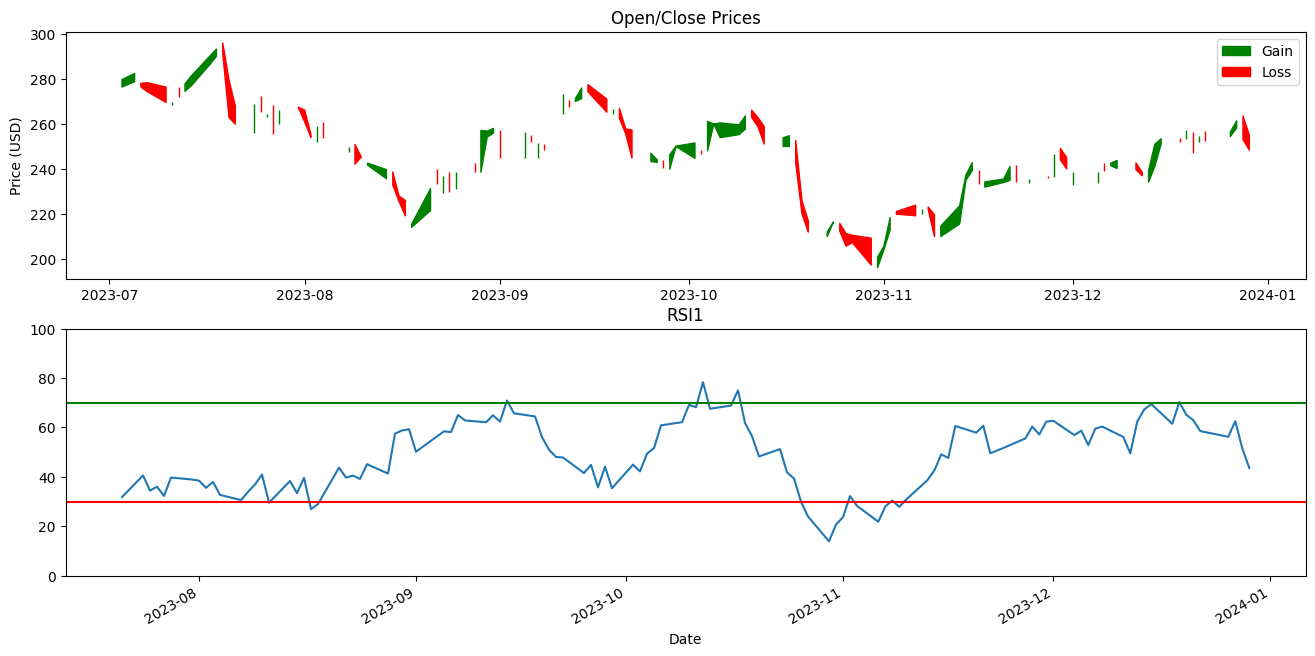

In [167]:
plot_charts(data, "RSI1")

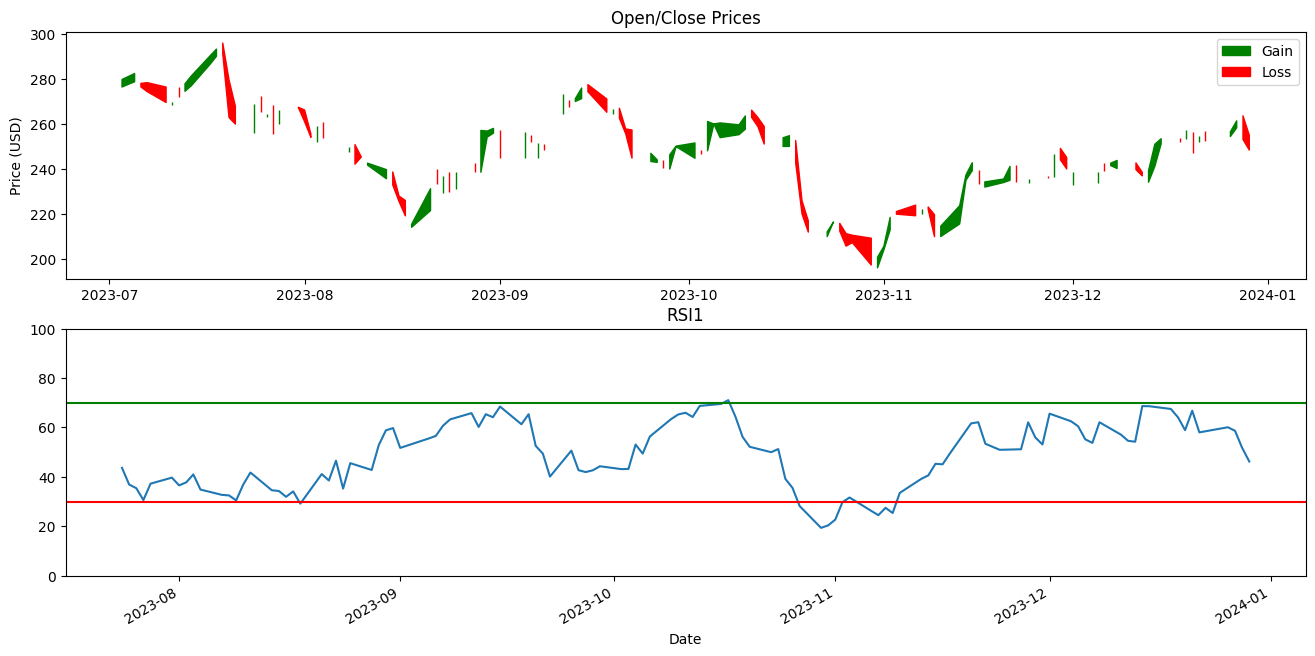

In [168]:
plot_charts(data, "RSI2")

**References:**

* Fernando, J. (Apr. 10, 2024). [Relative Strength Index (RSI) Indicator Explained With Formula](https://www.investopedia.com/terms/r/rsi.asp). Investopedia.
* StockCharts (nd). [Relative Strength Index (RSI)](https://chartschool.stockcharts.com/table-of-contents/technical-indicators-and-overlays/technical-indicators/relative-strength-index-rsi).

In [ ]:
).